In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import numpy as np
import scipy.stats as sp
import sklearn.preprocessing as skp

import math
from collections import namedtuple
from functools import partial

In [2]:
data = pd.read_csv("chips.txt", header = None)

X = data.values[:,:2]
Y = data.values[:,2]

np.random.seed(0)
random_permutation = np.random.permutation(len(X))
X = X[random_permutation]
Y = Y[random_permutation]

In [3]:
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

Params = namedtuple("Params", "k norm trans")

In [4]:
step = 0.01
x_min, y_min = np.amin(X, axis = 0) - step
x_max, y_max = np.amax(X, axis = 0) + step

In [5]:
def estimate(X, Y, point, params):
    distances = params.norm(X - point, axis = -1)
    return sp.mode(Y[np.argsort(distances)[:params.k]]).mode[0]

In [6]:
def cross_validate(X, Y, estimate, block_n):
    x_parts = np.array_split(X, block_n)
    y_parts = np.array_split(Y, block_n)
    accuracy = 0
    for i in range(block_n):
        x_train = np.concatenate(np.delete(x_parts, i, 0))
        y_train = np.concatenate(np.delete(y_parts, i, 0))
        x_test = x_parts[i]
        y_test = y_parts[i]
        test_accuracy = 0
        for x, y in zip(x_test, y_test):
            test_accuracy += (estimate(x_train, y_train, x) != y)
        accuracy += 1 - test_accuracy / len(x_train)
    return accuracy / block_n

In [7]:
def identity(x):
    return x

def polar(x):
    return np.column_stack([
        np.sqrt(x[:,0] ** 2 + x[:,1] ** 2),
        np.arctan2(x[:,1], x[:,0])
    ])

def withPolar(x):
    return np.concatenate([x, polar(x)], axis = 1)

params_set = [
    Params(k, partial(np.linalg.norm, ord = norm_ord), trans_f)
    for k in range(1, 21)
    for norm_ord in [-np.inf, 1, 1.5, 2, 2.5, 3, np.inf]
    for trans_f in [
        identity,
        skp.PolynomialFeatures(2, include_bias = False).fit_transform,
        polar,
        withPolar
    ]
]

In [8]:
params_accuracies = [cross_validate(p.trans(X), Y, partial(estimate, params = p), 5)
                     for p in params_set]

In [9]:
best_params = params_set[np.argmax(params_accuracies)]
print(cross_validate(best_params.trans(X), Y, partial(estimate, params = best_params), 5))
print(best_params)

0.957670772676
Params(k=7, norm=functools.partial(<function norm at 0x7fea780f6b70>, ord=inf), trans=<bound method TransformerMixin.fit_transform of PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)>)


In [10]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))
transX = best_params.trans(X)
transPoints = best_params.trans(np.column_stack([xx.reshape((-1)), yy.reshape((-1))]))
zz = np.array([estimate(transX, Y, p, best_params)
               for p in transPoints]
             ).reshape(xx.shape)

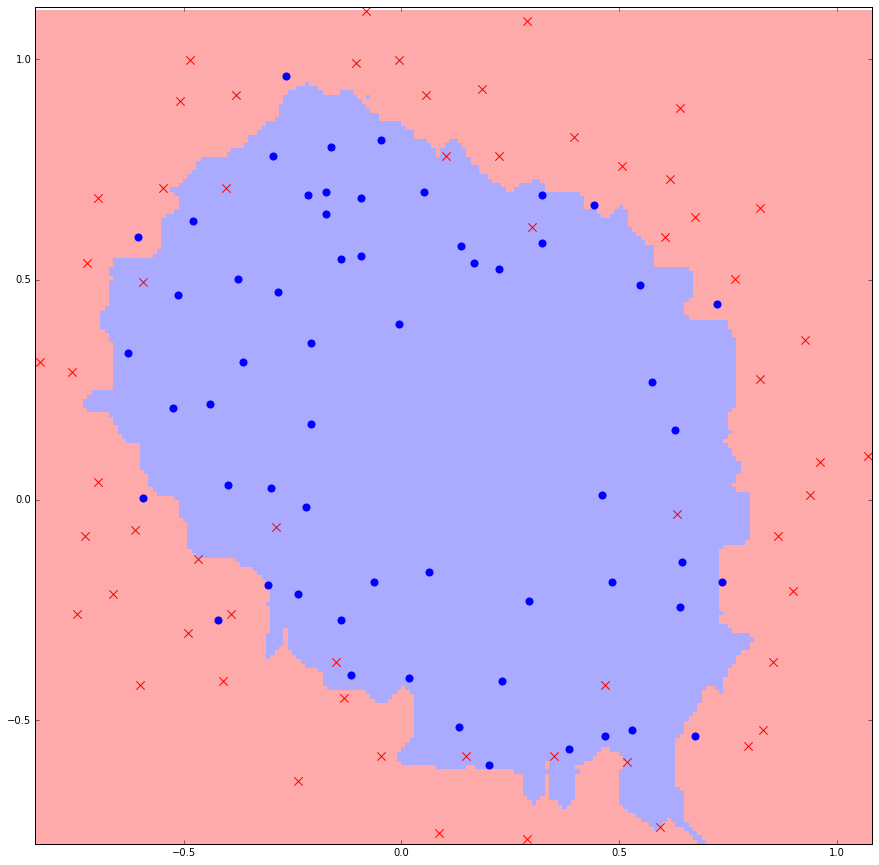

In [11]:
plt.figure(figsize=(15, 15))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

x0, y0 = X[Y == 0].T
x1, y1 = X[Y == 1].T

plt.pcolormesh(xx, yy, zz, cmap = cmap_light)
plt.scatter(x0, y0, marker = 'x', color = 'red',  s = 70)
plt.scatter(x1, y1, marker = 'o', color = 'blue', s = 50)